In [1]:
import pandas as pd

filepath_dict = {'yelp':   'sa_data/yelp_labelled.txt',
                 'amazon': 'sa_data/amazon_cells_labelled.txt',
                 'imdb':   'sa_data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [2]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


* corpus - collection of text
* vocab - list of words that are in the text with own index - creating a vector for a sentence
* feature vector - resulting vector, each dimension is a word with count

In [4]:
# setting up baseline model
# use of .values returns a numpyarray - easier to work with 

from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [5]:
# using vocab only of training data
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [6]:
# 750 samples (number of training sample/rows) each with 2505 dimensions (size of vocabulary)
# sparse matrix - data type optimized for matrices with only a few non-zero elements - only track non-zero
# count vectorizer - already does tokenization - can be customized further - stopwords, etc. 

In [7]:
# base model with LogReg
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


In [8]:
# for loop for every source
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


In [34]:
# apply NN to NLP
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compile to set optimizer and loss
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                25060     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 25060 = 2505 (features) * 10 (nodes in layer) = 25050 +10(bias for each node)
# 11 (params) = 10 nodes + 1 bias 

# epochs 100 - number of iterations
# batch-size - how many samples per epoch, used in forward and backward pass, speeds up computation (larger batch) but may degrade model - with loss function calculation?
# larger batch size needs more memory 
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

/opt/homebrew/Caskroom/miniforge/base/envs/lhl_env38/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [29]:
# if rerunning .fit - to restart - must also restart add and compile model
from keras.backend import clear_session
clear_session()

In [36]:
# evaluating accuracy of the model
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9947
Testing Accuracy:  0.7914


In [37]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

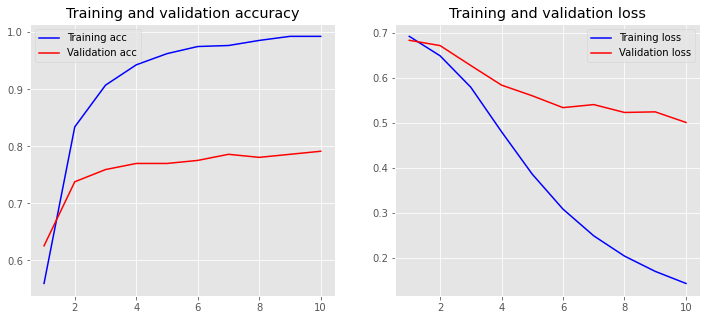

In [38]:
plot_history(history)

In [39]:
# validation data should be separate from test data 

Separate ways to represent words as vectors:
1. one hot encoding
    * tag 1 when word occurs, else 0 
    * can use LabelEncoder to tag 
    * sparse data may need to be reshaped 
2. word embeddings
    * represents words as dense word vectors
    * collects more information
    * map statistical structure of language

Keras tokenizer
* vectorize text into a list of integers 
* each integer maps to a value in a dictionary - that encodes the corpus
* keys = vocab terms
* num_words = size of vocab - keeps the most common

In [40]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


In [50]:
# indexing order - is based on most common words in the text. 'a' has number 2 index - very common
# zero index is used for padding - which is why 1 was added to vocab_size index
# word_count + 1 for unknown words (not in vocab)
# CountVectorizer - stacked vectors of word counts - each vector the same length
# Tokenizer - vectors = length of each text - numbers are NOT counts, but word values from the tokenizer dictionary

for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27


KeyError: 'happy'

In [51]:
# since it is uneven - need to pad the sequence of words with 0, can append or prepend
# so features are all the same - from a large premade dictionary
# set maxlen params for how long sequences should be 
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [53]:
sentences_train[0]

'Definitely worth checking out.  '

In [55]:
# if rerunning .fit - to restart - must also restart add and compile model
from keras.backend import clear_session
clear_session()

In [56]:
# Using the Embedding Layer of Keras - takes previously calculated integers - maps to a dense vector of the embedding
# need: input_dim (size of vocab), output_dim (size of dense vector), input_length (length of sequence)
# from embedding layer - flatten then plug into dense layer 

from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           128750    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.6845


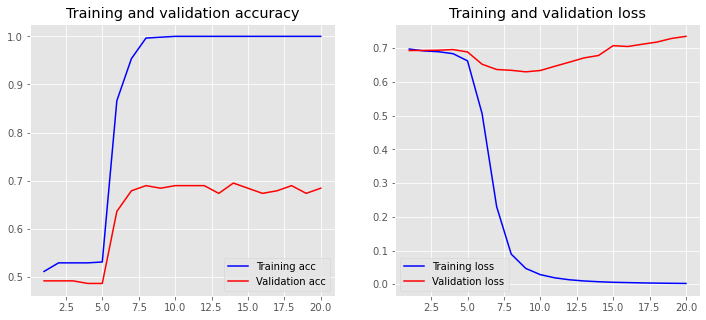

In [58]:
# embedding based on = vocab_size (2575) * embedding_dim (10) - weights adjusted with backprop
# words taken as input vectors
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [59]:
# can also use Max/Average Pooling after embedding - to reduce size of incoming vectors (similar to CNN layer)
# takes the max value of all features in the pool for reach feature dimension (func is max, average etc.)
# global - means there's no window? and takes all features (no pool size)
from keras.backend import clear_session
clear_session()

In [60]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7701


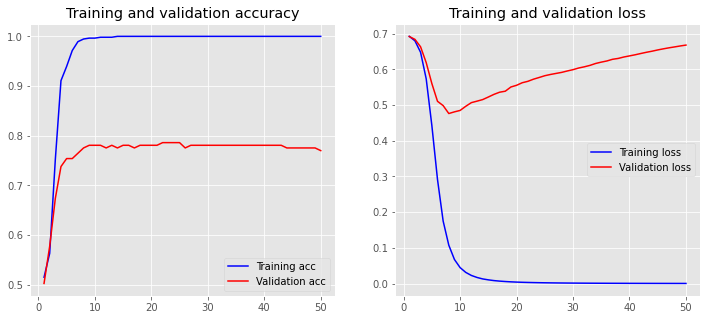

In [61]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
# note the reduction in features after pooling, and increase accuracy

In [62]:
# can also use embedding space with much larger corpus (i.e. word2vec (accuracy) and GloVe (for speed))
# can be done with gensim
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [64]:
embedding_dim = 50 # setting the number of dimensions - because the vocab is not large for our use
embedding_matrix = create_embedding_matrix(
    '/Users/franzv/glove6B_embedding/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [65]:
# how many non-zero, number of data/words covered by the embedding 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9522330097087378

In [66]:
from keras.backend import clear_session
clear_session()

In [67]:
# attempt with new embedding
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


Training Accuracy: 0.7504
Testing Accuracy:  0.7487


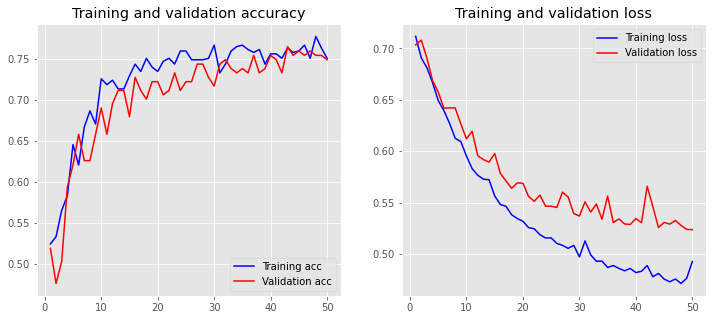

In [69]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [70]:
# less overfitting - since embeddings are not trained - lower is expected... see diff when trainable is true 
from keras.backend import clear_session
clear_session()

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7754


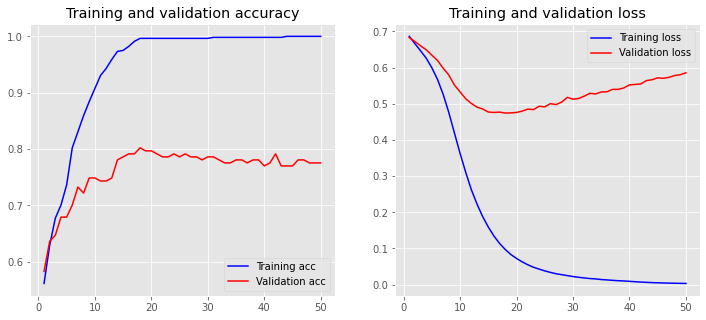

In [71]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

#### USing ConvNets - more advanced NN model
* certain sequences recognized at different positions

In [72]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu')) # adds convolution layer
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          257500    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
________________________________________________

Training Accuracy: 1.0000
Testing Accuracy:  0.7647


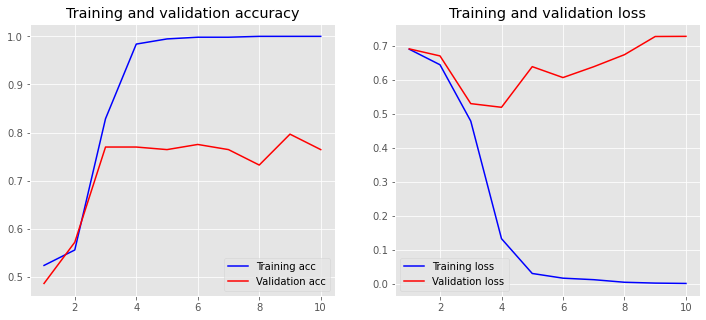

In [73]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

stuck at 80% accuracy:
* not enough samples
* data doesn't generalize well - sampling bias
* need to tweak hyperparams

Applying random search for parameters
* kerasClassifier - wrapper for scikit-learn API
* used to do RandomizedSearchCV
* and k-fold cross validation

In [74]:
# create function with keras model - mod arguments for parameters
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [75]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])
# njobs=-1 to run things in parallel                

In [77]:
# with added code for evaluation - added CV, and keras classifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 5 # changed epoch for speed 
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model, # wrapper to be able to use within this forloop?
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipykernel_53653/3259138037.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model, # wrapper to be able to use within this forloop?
